In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os 
import pickle
import timeit
import math
import time
import sparse
import dask
import dask.array as da
from dask.diagnostics import ProgressBar
from scipy import interpolate
from pylab import *
from numpy import *
from glob import glob
from os import path
from tqdm import tqdm

In [2]:
outputDir = 'data/posterior_computation_data/'
gom_masks = xr.open_dataset(outputDir + 'gom_masks.nc')

# GLOBAL CONSTANTS
MIN_LON = np.min(gom_masks['lon'].values)
MAX_LON = np.max(gom_masks['lon'].values)
MIN_LAT = np.min(gom_masks['lat'].values)
MAX_LAT = np.max(gom_masks['lat'].values)

#domain width and height (cell counts)
LAT_SIZE = gom_masks.dims['lat']
LON_SIZE = gom_masks.dims['lon']

#cell size
D_LON = gom_masks["lon"][1].values - gom_masks["lon"][0].values
D_LAT = gom_masks["lat"][1].values - gom_masks["lat"][0].values

BIN_CELL_LATS = gom_masks.bin_cell_lats.values
BIN_CELL_LONS = gom_masks.bin_cell_lons.values

MIN_LON, MAX_LON, MIN_LAT, MAX_LAT,LAT_SIZE,LON_SIZE, D_LON,D_LAT

(-97.98001098632812,
 -76.45999145507812,
 18.140000343322754,
 31.899998664855957,
 345,
 539,
 0.03997802734375,
 0.03999900817871094)

In [3]:
# Load domain_cell_tree
fileObj = open(outputDir + 'output_dict.obj', 'rb')
output = pickle.load(fileObj)
fileObj.close()

In [4]:
n_cell_beaching = output['n_cell_beaching']
n_cell_source = output['n_cell_source']
n_window_beaching = output['n_window_beaching'] 
n_window_source = output['n_window_source']

particle_count = output['particle_count']

beaching_cells = output['beaching_cells'] 
beaching_cell_tree = output['beaching_cell_tree']

source_cell_mask = output['source_cell_mask']
source_cells = output['source_cells']
source_cell_tree = output['source_cell_tree']

beaching_windows = output['beaching_windows']
source_windows = output['source_windows']
d = output['d']
beaching_ym_mat = output['beaching_ym_mat']
source_ym_mat = output['source_ym_mat']

n_cell_beaching,n_cell_source,n_window_beaching, n_window_source

(188, 114024, 30, 36)

In [5]:
# Load agg values
fileObj = open(outputDir + 'agg_dict.obj', 'rb')
output = pickle.load(fileObj)
fileObj.close()

In [6]:
source_cell_groups = output['source_cell_groups']
beaching_cell_groups = output['beaching_cell_groups'] 
beaching_window_groups = output['beaching_window_groups']
group_source_region = output['group_source_region']
group_beaching_region = output['group_beaching_region']
group_beaching_month = output['group_beaching_month']
group_source_region_names = output['group_source_region_names']

Aggregate Posterior Quantities

In [8]:
n_post = xr.open_zarr(outputDir + 'n_post.zarr')

n_post = n_post.assign_coords(source_cell_groups = ("dsource_windows_cells", source_cell_groups))
n_post = n_post.assign_coords(beaching_cell_groups = ("beaching_window_cells", beaching_cell_groups))
n_post = n_post.assign_coords(beaching_window_groups = ("beaching_window_cells", beaching_window_groups))

Figure 11

In [11]:
# with ProgressBar():
#     l_n_post = n_post.l_n_post.compute()
#     r_n_post = n_post.r_n_post.compute()
#     f_n_post = n_post.f_n_post.compute()

print('groupby( source_cell_groups ).sum() * particle_count')
tic=time.time()
l_gb_nn_source_cell = n_post.l_n_post.groupby('source_cell_groups').sum() * np.ravel(particle_count.T) 
r_gb_nn_source_cell = n_post.r_n_post.groupby('source_cell_groups').sum() * np.ravel(particle_count.T) 
f_gb_nn_source_cell = n_post.f_n_post.groupby('source_cell_groups').sum() * np.ravel(particle_count.T) 
print('   done in',time.time()-tic)

print('groupby( beaching_cell_groups ).sum() / rowSums(particle_count)')
tic=time.time()
l_gb_n_source_cell = l_gb_nn_source_cell.groupby('beaching_cell_groups').sum() / np.sum(particle_count, axis = 1)
r_gb_n_source_cell = r_gb_nn_source_cell.groupby('beaching_cell_groups').sum() / np.sum(particle_count, axis = 1)
f_gb_n_source_cell = f_gb_nn_source_cell.groupby('beaching_cell_groups').sum() / np.sum(particle_count, axis = 1)
print('   done in',time.time()-tic)

Figure_11_l_raw = (l_gb_n_source_cell * np.sum(particle_count, axis = 1)).sum(dim = 'beaching_cell_groups') / np.sum(particle_count)
Figure_11_r_raw = (r_gb_n_source_cell * np.sum(particle_count, axis = 1)).sum(dim = 'beaching_cell_groups') / np.sum(particle_count)
Figure_11_f_raw = (f_gb_n_source_cell * np.sum(particle_count, axis = 1)).sum(dim = 'beaching_cell_groups') / np.sum(particle_count)

with ProgressBar():
    Figure_11_l_raw = Figure_11_l_raw.compute()
    Figure_11_r_raw = Figure_11_r_raw.compute()
    Figure_11_f_raw = Figure_11_f_raw.compute()

groupby( source_cell_groups ).sum() * particle_count
   done in 14.143882036209106


In [15]:
Figure_11_l_raw.to_netcdf(outputDir + 'Figure_11_l_raw.nc')
Figure_11_r_raw.to_netcdf(outputDir + 'Figure_11_r_raw.nc')
Figure_11_f_raw.to_netcdf(outputDir + 'Figure_11_f_raw.nc')

Posterior Source Type Proportions

In [16]:
l_prop = np.sum(Figure_11_l_raw).values
r_prop = np.sum(Figure_11_r_raw).values
f_prop = np.sum(Figure_11_f_raw).values

In [17]:
l_prop, r_prop, f_prop, (l_prop + r_prop + f_prop)

(array(0.52302712), array(0.07172071), array(0.40445315), 0.9992009783004037)

Aggregate Over All Source Types

In [9]:
with ProgressBar():
    all_n_post = (n_post.l_n_post + n_post.r_n_post + n_post.f_n_post).compute()
    
print('Get Total of Posterior Sum')
tic=time.time()
all_n_post_sum = np.sum(all_n_post)
print('   done in',time.time()-tic)

[########################################] | 100% Completed | 85.98 s
Get Total of Posterior Sum
   done in 71.55976629257202


In [10]:
all_n_post = all_n_post.assign_coords(source_cell_groups = ("dsource_windows_cells", source_cell_groups))
all_n_post = all_n_post.assign_coords(beaching_cell_groups = ("beaching_window_cells", beaching_cell_groups))
all_n_post = all_n_post.assign_coords(beaching_window_groups = ("beaching_window_cells", beaching_window_groups))

Aggregation

In [11]:
print('groupby( source_cell_groups ).sum() * particle_count')
tic=time.time()
gb_nn_source_cell = all_n_post.groupby('source_cell_groups').sum() * np.ravel(particle_count.T) 
print('   done in',time.time()-tic)

groupby( source_cell_groups ).sum() * particle_count
   done in 170.0494556427002


All Source Posterior Map (Fig 11 greyscaled)

In [12]:
print('groupby( beaching_cell_groups ).sum() / rowSums(particle_count)')
tic=time.time()
gb_n_source_cell = gb_nn_source_cell.groupby('beaching_cell_groups').sum() / np.sum(particle_count, axis = 1)
print('   done in',time.time()-tic)

Figure_11_raw = (gb_n_source_cell * np.sum(particle_count, axis = 1)).sum(dim = 'beaching_cell_groups') / np.sum(particle_count)

groupby( beaching_cell_groups ).sum() / rowSums(particle_count)
   done in 10.040788650512695


In [13]:
Figure_11_raw.to_netcdf(outputDir + 'Fig11_greyscale.nc')

/tmp/ipykernel_174095/2747225327.py:4: RuntimeWarning: divide by zero encountered in log10
  (gom_masks.landmask + np.log10(Figure_11)).plot()


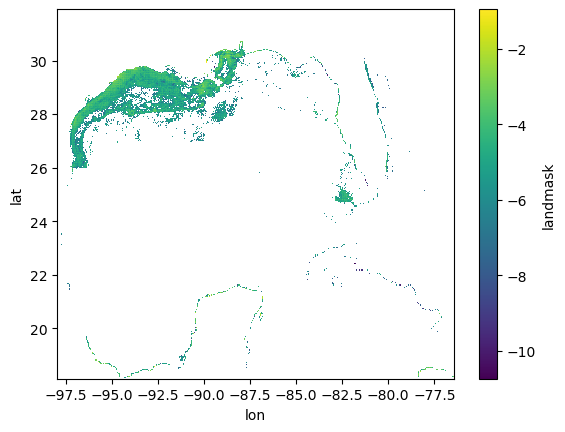

In [14]:
Figure_11 = np.zeros((LAT_SIZE, LON_SIZE))
Figure_11[source_cell_mask] = Figure_11_raw

(gom_masks.landmask + np.log10(Figure_11)).plot()

Source Region by Beaching Region  (Fig 9)

In [16]:
gb_n_source_cell = gb_n_source_cell.assign_coords(group_source_region = ("source_cell_groups", group_source_region))
gb_n_source_cell = gb_n_source_cell.assign_coords(group_beaching_region = ("beaching_cell_groups", group_beaching_region))

# Sum over GoM Regions
gb_n_source_region = gb_n_source_cell.groupby('group_source_region').sum() 

# Calculate sum of nurdles per beaching region
nb_df_groups = pd.DataFrame(particle_count, columns = np.arange(n_window_beaching), index = group_beaching_region).stack().reset_index()
nb_df_group_sums = nb_df_groups.groupby(['level_0'])[0].sum()

# Calculate Weighted Average
gb_n_source_region = (gb_n_source_region * np.sum(particle_count, axis = 1)).groupby('group_beaching_region').sum() / nb_df_group_sums.values

In [17]:
gb_n_source_region.to_netcdf(outputDir + 'Fig9.nc')

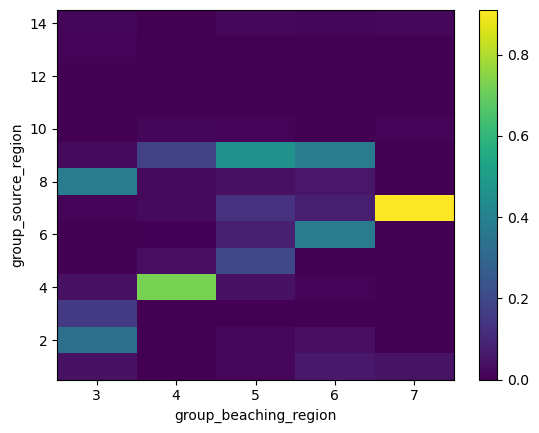

In [18]:
gb_n_source_region.plot()

Beaching Window by Source Region (Fig 13)

In [19]:
gb_n_beaching_windows = gb_nn_source_cell.groupby('beaching_window_groups').sum() / np.sum(particle_count, axis = 0)

gb_n_beaching_windows = gb_n_beaching_windows.assign_coords(group_source_region = ("source_cell_groups", group_source_region))
gb_n_beaching_windows = gb_n_beaching_windows.assign_coords(group_beaching_month = ("beaching_window_groups", group_beaching_month))

# Sum over GoM Regions
gb_n_sr_beaching_windows = gb_n_beaching_windows.groupby('group_source_region').sum() 

nb_df_periods = pd.DataFrame(particle_count.T, columns = np.arange(n_cell_beaching), index = group_beaching_month).stack().reset_index()
nb_df_period_sums = nb_df_periods.groupby(['level_0'])[0].sum()

gb_n_sr_beaching_windows = (gb_n_sr_beaching_windows * np.sum(particle_count, axis = 0)).groupby('group_beaching_month').sum() / nb_df_period_sums.values

In [20]:
gb_n_sr_beaching_windows.to_netcdf(outputDir + 'Fig13.nc')

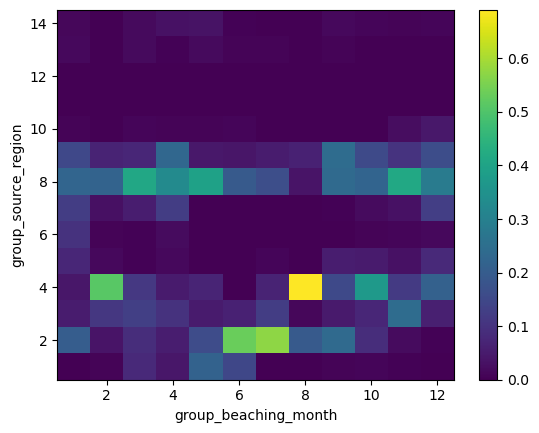

In [21]:
gb_n_sr_beaching_windows.plot()

Thicken Coast Doesn't Really Work Here Because it is Squished in Xarray plotting

In [43]:
def extend_coastline(data):
    within_r_idx = np.where(~np.isnan(gom_masks.plotcoastidx))
    coastal_idx_within_r_idx = np.array(gom_masks.plotcoastidx.values[within_r_idx], dtype = int)

    idx_coast_mask = np.where(gom_masks.coastalmask == 1)
    data_vals = data[idx_coast_mask]
    
    vals_within_r = np.zeros( (LAT_SIZE, LON_SIZE) )
    vals_within_r[within_r_idx] = data_vals[coastal_idx_within_r_idx]
    
    return vals_within_r

In [44]:
plot_Figure_11 = extend_coastline(np.log10(Figure_11))
plot_Figure_11[plot_Figure_11 == 0.0] = np.nan
gom_masks = gom_masks.assign(plot_Figure_11 = (('lat', 'lon'), plot_Figure_11))

/tmp/ipykernel_206535/1147477520.py:1: RuntimeWarning: divide by zero encountered in log10
  plot_Figure_11 = extend_coastline(np.log10(Figure_11))


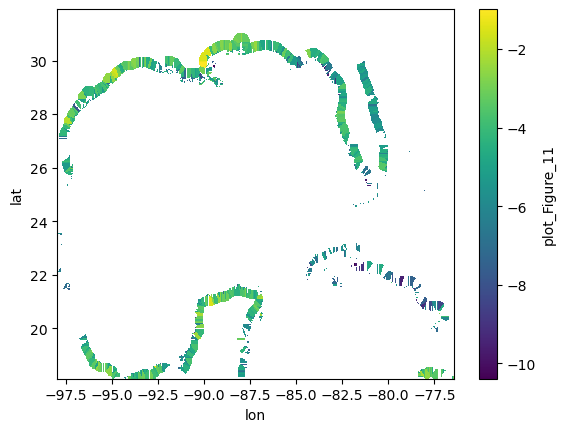

In [50]:
gom_masks.plot_Figure_11.plot()

In [52]:
# remove zarr
# import shutil
# shutil.rmtree(outputDir + '/source_agg_n_post.zarr', ignore_errors=True)